In [1]:
import datetime
import pandas_datareader.data as web

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
ticker='ANO.AX'
months=72
today=datetime.date(2019,5,31)

start=datetime.date(2012,1,1)
end =datetime.date(2019,4,30)
dataset_train=web.DataReader(ticker,"yahoo",start,end)  
training_set = dataset_train.iloc[:, 0:1].values

# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(1852, 1)

In [2]:
len(dataset_train)


1852

In [3]:
# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, len(dataset_train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [4]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [5]:
# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Show the dataset we're working with
display(X_train)



array([[[0.00812389],
        [0.01218684],
        [0.01218684],
        ...,
        [0.00812389],
        [0.00812389],
        [0.00812389]],

       [[0.01218684],
        [0.01218684],
        [0.01218684],
        ...,
        [0.00812389],
        [0.00812389],
        [0.00812389]],

       [[0.01218684],
        [0.01218684],
        [0.01218684],
        ...,
        [0.00812389],
        [0.00812389],
        [0.00812389]],

       ...,

       [[0.28456157],
        [0.28049659],
        [0.27846409],
        ...,
        [0.8597578 ],
        [0.82317291],
        [0.87195276]],

       [[0.28049659],
        [0.27846409],
        [0.28862656],
        ...,
        [0.82317291],
        [0.87195276],
        [0.94512262]],

       [[0.27846409],
        [0.28862656],
        [0.32317898],
        ...,
        [0.87195276],
        [0.94512262],
        [0.98780504]]])

In [6]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1792/1792 [==============================] - 9s 5ms/step - loss: 0.0043
Epoch 2/100
1792/1792 [==============================] - 7s 4ms/step - loss: 8.9574e-04
Epoch 3/100
1792/1792 [==============================] - 7s 4ms/step - loss: 0.0011
Epoch 4/100
1792/1792 [==============================] - 7s 4ms/step - loss: 7.3024e-04
Epoch 5/100
1792/1792 [==============================] - 7s 4ms/step - loss: 9.7273e-04
Epoch 6/100
1792/1792 [==============================] - 7s 4ms/step - loss: 8.9941e-04
Epoch 7/100
1792/1792 [==============================] - 7s 4ms/step - loss: 0.0010
Epoch 8/100
1792/1792 [==============================] - 7s 4ms/step - loss: 6.4771e-04
Epoch 9/100
1792/1792 [==============================] - 7s 4ms/step - lo

1792/1792 [==============================] - 7s 4ms/step - loss: 3.6597e-04
Epoch 84/100
1792/1792 [==============================] - 7s 4ms/step - loss: 4.1757e-04
Epoch 85/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.1865e-04
Epoch 86/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.7193e-04
Epoch 87/100
1792/1792 [==============================] - 7s 4ms/step - loss: 2.3721e-04
Epoch 88/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.0345e-04
Epoch 89/100
1792/1792 [==============================] - 7s 4ms/step - loss: 2.9170e-04
Epoch 90/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.5187e-04
Epoch 91/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.4916e-04
Epoch 92/100
1792/1792 [==============================] - 7s 4ms/step - loss: 2.8481e-04
Epoch 93/100
1792/1792 [==============================] - 7s 4ms/step - loss: 3.1499e-04
Epoch 94/100
1792/1792 [==========

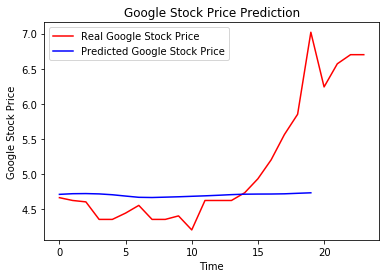

In [7]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017


dataset_test=web.DataReader(ticker,"yahoo",end,today)  
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()
